In this EDA I'll explore a house price dataset. The dataset is collected from a Kaggle playground competition. You can check the dataset from here. https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. I'll try to analyse some variables and their impact to determine the house price. Besides, I'll try to do some basic data cleaning.

First thing first. Let's import the necessary libraries.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
import xgboost
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the data
train_df = pd.read_csv('./drive/My Drive/kaggle/train.csv')
test_df = pd.read_csv('./drive/My Drive/kaggle/test.csv')

In [3]:
print ('%d rows and %d columns in training data'%(train_df.shape[0], train_df.shape[1]))
print ('%d rows and %d columns in testing data'%(test_df.shape[0], test_df.shape[1]))

1460 rows and 81 columns in training data
1459 rows and 80 columns in testing data


In [4]:
# columns in the data
print (train_df.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Id column is unnecessary for our cause. Remove this column first.

In [5]:
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

Our goal is to predict the *SalePrice* using the other features. Let's look at the *SalePrice* column.

In [6]:
train_df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Well, the minimum value in the *SalePrice* is 34900. That means there is no negative or zero value in the target. We are good to go. We can look at the distribution now.

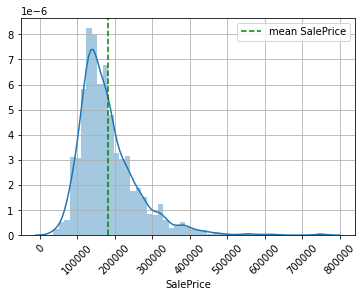

In [7]:
sns.distplot(train_df.SalePrice)
plt.axvline(train_df.SalePrice.mean(), linestyle='--', c='g', label='mean SalePrice')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

Ok, the *SalePrice* is not normally distributed and shows [positive skewness](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa).

Let's look at a snapshot of the training data.

In [8]:
train_df.sample(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1073,60,RL,75.0,7950,Pave,NaN,IR1,Bnk,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,2Story,6,6,1977,1977,Hip,CompShg,HdBoard,Plywood,BrkFace,140.0,TA,TA,CBlock,TA,TA,No,BLQ,535,Unf,0,155,690,GasA,TA,Y,SBrkr,698,728,0,1426,0,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1977.0,Fin,2,440,TA,TA,Y,252,0,0,0,0,0,NaN,MnPrv,NaN,0,7,2009,WD,Normal,159500
953,60,RL,NaN,11075,Pave,NaN,IR1,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,5,4,1969,1969,Gable,CompShg,HdBoard,HdBoard,BrkFace,232.0,TA,TA,CBlock,TA,TA,Av,ALQ,562,LwQ,193,29,784,GasA,Ex,Y,SBrkr,1168,800,0,1968,0,1,2,1,4,1,TA,7,Min2,1,Po,Attchd,1969.0,RFn,2,530,TA,TA,Y,305,189,0,0,0,0,NaN,MnPrv,Shed,400,9,2008,WD,Normal,172000
352,50,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Artery,Norm,1Fam,1.5Fin,5,6,1941,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,Fa,Mn,LwQ,236,Rec,380,0,616,GasA,TA,N,SBrkr,616,495,0,1111,0,1,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1941.0,Unf,1,200,TA,Fa,Y,48,0,0,0,0,0,NaN,NaN,NaN,0,3,2008,ConLw,Normal,95000
196,20,RL,79.0,9416,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2007,Hip,CompShg,CemntBd,CmentBd,Stone,205.0,Ex,TA,PConc,Ex,TA,No,GLQ,1126,Unf,0,600,1726,GasA,Ex,Y,SBrkr,1726,0,0,1726,1,0,2,0,3,1,Ex,8,Typ,1,Gd,Attchd,2007.0,Fin,3,786,TA,TA,Y,171,138,0,0,266,0,NaN,NaN,NaN,0,9,2007,New,Partial,311872
13,20,RL,91.0,10652,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,Stone,306.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1494,1494,GasA,Ex,Y,SBrkr,1494,0,0,1494,0,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,3,840,TA,TA,Y,160,33,0,0,0,0,NaN,NaN,NaN,0,8,2007,New,Partial,279500
653,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,6,7,1906,1995,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,756,756,GasA,Ex,Y,SBrkr,756,713,0,1469,0,0,1,0,3,1,TA,7,Typ,0,NaN,Detchd,1906.0,Unf,1,216,TA,TA,Y,57,0,239,0,0,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,135000
355,20,RL,105.0,11249,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,6,5,1995,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,Gd,PConc,Gd,Gd,No,ALQ,334,BLQ,544,322,1200,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,1995.0,RFn,2,521,TA,TA,Y,0,26,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,177500
882,60,RL,NaN,9636,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1992,1993,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,808,808,GasA,Gd,Y,SBrkr,808,785,0,1593,0,0,2,1,3,1,TA,7,Typ,1,TA,BuiltIn,1993.0,RFn,2,389,TA,TA,Y,342,40,0,0,0,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,178000
1217,20,FV,72.0,8640,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2009,2009,Gable,CompShg,CemntBd,CmentBd,Stone,72.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,936,Unf,0,364,1300,GasA,Ex,Y,SBrkr,1314,0,0,1314,1,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2009.0,RFn,2,552,TA,TA,Y,135,112,0,0,0,0,NaN,NaN,NaN,0,9,2009,New,Partial,229456
1270,40,RL,NaN,23595,Pave,NaN,Reg,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,6,1979,1979,Shed,WdShake,Plywood,Plywood,None,0.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1258,Unf,0,74,1332,GasA,TA

There are both numerical and categorical features in the dataset. Now we will group all the features into these two groups. All *object* type columns will be considered as categorical, rest of the columns are numerical.

In [9]:
train_df_categorical = train_df.select_dtypes(include='object')
train_df_numerical = train_df.select_dtypes(exclude='object')

In [10]:
train_df_categorical

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [11]:
train_df_numerical

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


The next question is how the numerical columns are related to the *SalePrice* column? We can check this relationship using a correlation matrix. Only showing the correlation larger than 0.5

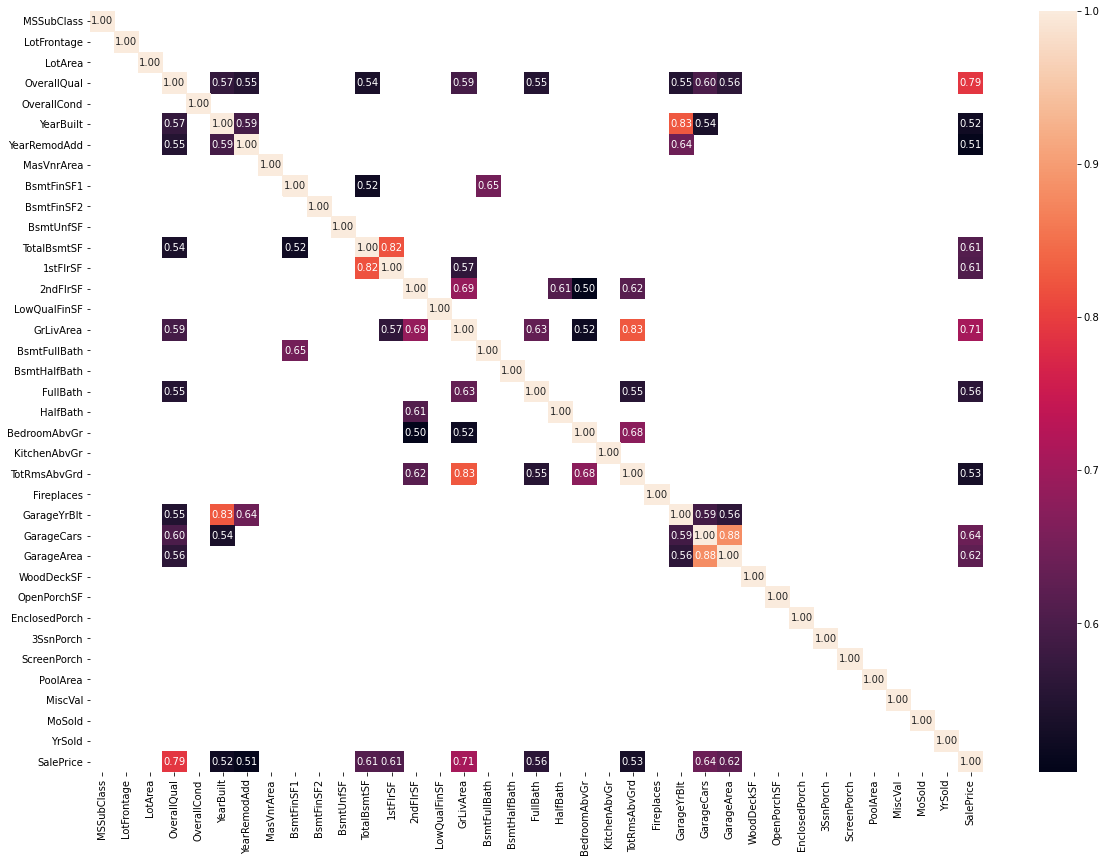

In [12]:
corr = train_df_numerical.corr()
corr = corr[corr > 0.5]
plt.figure(figsize=(20, 14))
sns.heatmap(corr, annot=True, fmt='.2f')

Now we will check a smaller version of the above correlation matrix. We will visualize the correlation among the top 10 highly correation fetatures with the *SalePrice*.

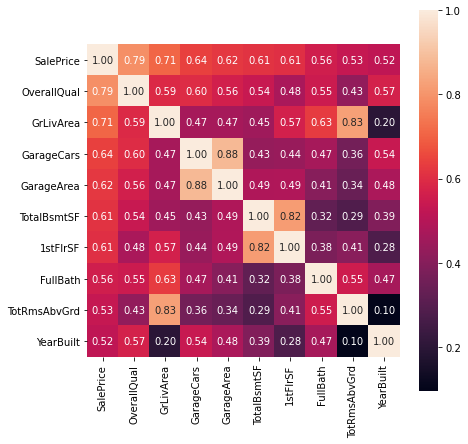

In [13]:
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df_numerical[cols].values.T)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Well, *OverallQual* and *GrLivArea* are two most strongly correlated features with *SalePrice*.

*GarageArea* and *GarageCars* are highly correalted. It seems number of cars in the garage is related to the garage size.

*TotalBsmtSF* and *1stFlrSF* are strongly correlated too. Seems normal.

*FullBath* and *TotRmsAbvGrd* are highly correlated to *GrLivArea*. This relation is expected too.

IMO, *YearBuilt* should have a higher correlation with *SalePrice*. But it seems pretty low here. We will investigate this property late.



Now we will draw some plots to visualize the relationship between *SalePrice* and some highly correlated features.

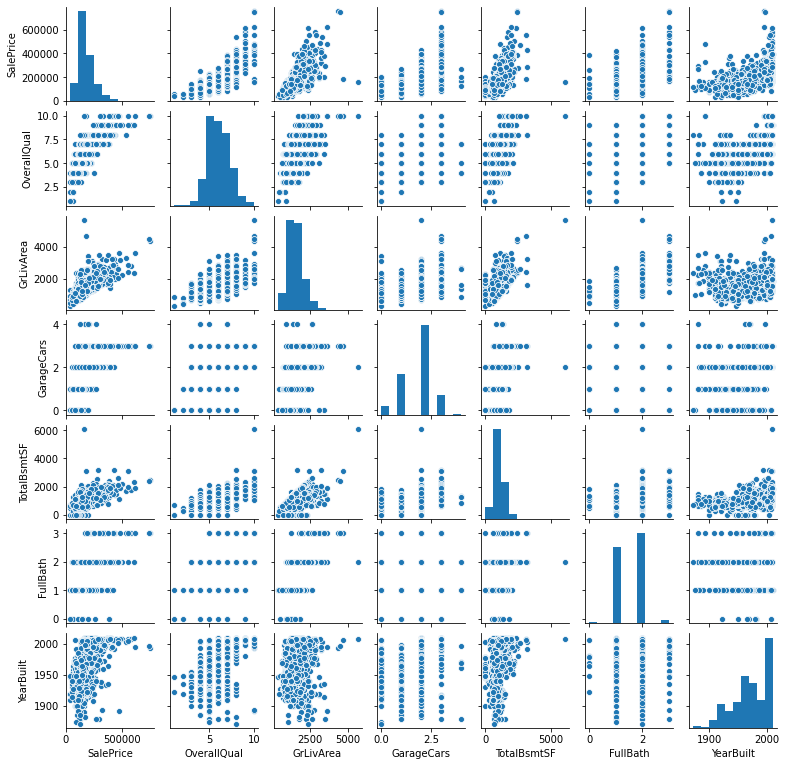

In [14]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df_numerical[cols], height = 1.5) 

Now we will perform some missing data analysis. Let's find out how many data are missing in each feature.

In [15]:
total = train_df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame(total).reset_index()
missing_df.columns = ['feature', 'missing values']
missing_df.head(20)

,feature,missing values
0,PoolQC,1453
1,MiscFeature,1406
2,Alley,1369
3,Fence,1179
4,FireplaceQu,690
5,LotFrontage,259
6,GarageType,81
7,GarageCond,81
8,GarageFinish,81
9,GarageQual,81


*GarageType*, *GarageCond*, *GarageFinish*, *GarageQual* and *GarageYrBlt* has same amount of missing values! Seems like all of these are derived from a similar source.

Besides, *BsmtQual*, *BsmtCond* and *BsmtFinType1* has similar number of missing values too.

Just learnt about the *info* function. It shows a concise summary of a dataframe. Check this out. It shows the data type and number of non-null values for each features.

In [16]:
print (train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

We want to see a boxplot of our *SalePrice* column. Here it is. Its an enhanced version of boxplot. The left and the rightmost points are the outliers.

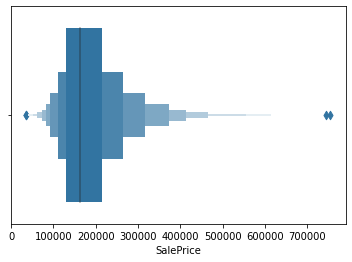

In [17]:
sns.boxenplot(train_df.SalePrice)

Let's analyze the *OverallQual* feature. First thing first. What is the distribution of this feature?

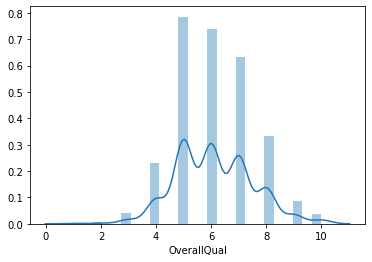

In [18]:
sns.distplot(train_df.OverallQual)

Rating *5* is the most common in the *OverallQual* feature. Let's draw a boxplot to better visualize the relationship between *OverallQual* and *SalePrice*. For each quality it will show the five number summary (minimum, maximum, median, first and third quartile) of corresponding *SalePrice*. We can have a sense of data dispersion and outlier from this plot.

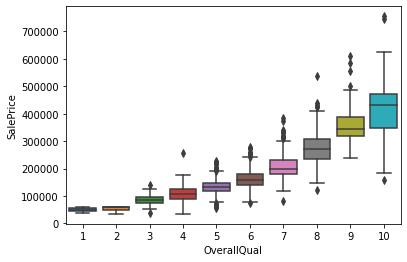

In [19]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)

Now we'll plot the correlation of *SalePrice* with all other features.

Text(0.5, 1.0, 'correlation with SalePrice')

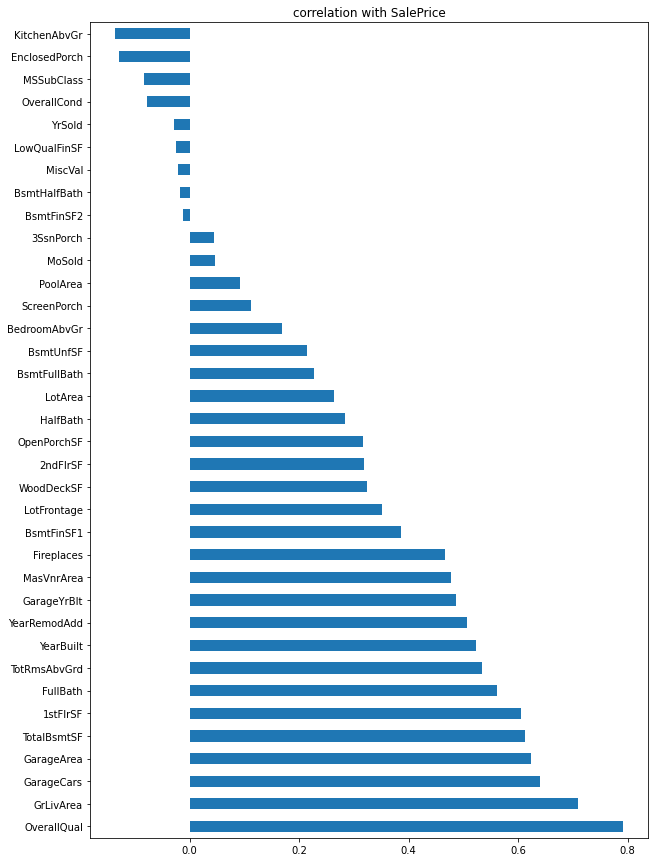

In [20]:
corr = train_df.corr()
SP_corr = corr['SalePrice'].sort_values(ascending=False)[1:]

plt.figure(figsize=(10, 15))
SP_corr.plot(kind='barh')
plt.title('correlation with SalePrice')

We've seen that *SalePrice* is not normally distributed. We'll perform log transform on this target to see the impact.

Text(0.5, 1.0, 'Log transformed SalePrice')

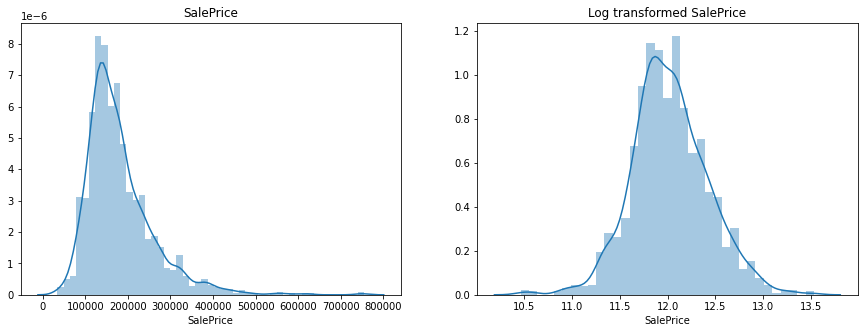

In [21]:
saleprice_lt = np.log(train_df['SalePrice'])

fig ,axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = np.array(axs)
sns.distplot(saleprice_lt, ax=axs[1])
sns.distplot(train_df['SalePrice'], ax=axs[0])
axs[0].set_title('SalePrice')
axs[1].set_title('Log transformed SalePrice')

We'll use the log transformed *SalePrice* for modelling purpose.

Now, we'll use xgboost regression on this dataset to find the validation accuracy and importance of each features for predicting the house price. This is a very basic model without any feature engineering.

In [22]:
y = train_df.SalePrice
X = train_df.drop('SalePrice', axis=1)

Before starting the modelling, we need to find the categorical features and change the to one hot encoded features. Here is our categorical and numerical features.

In [23]:
train_df_categorical = train_df.select_dtypes(include='object')
train_df_numerical = train_df.select_dtypes(exclude='object')

Let's check how many unique values in each of the features.

Text(0.5, 1.0, 'number of unique values in categorical features')

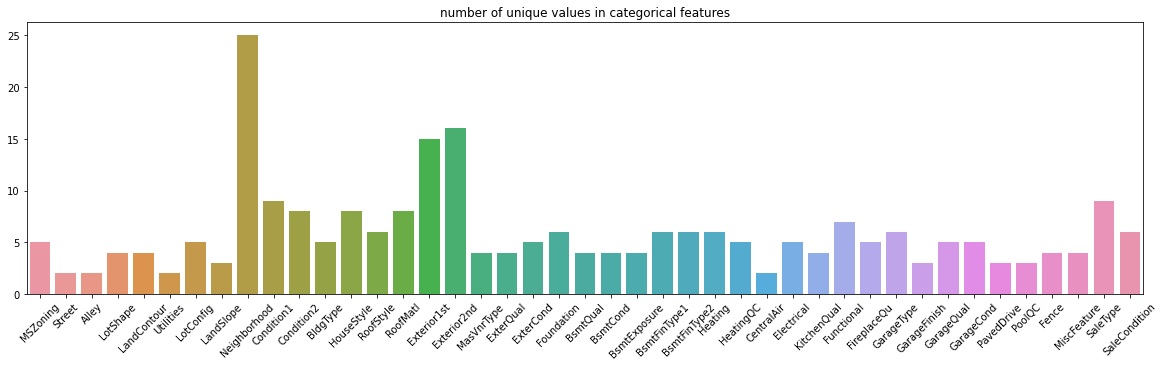

In [24]:
cat_unique = train_df_categorical.nunique()
plt.figure(figsize=(20, 5))
sns.barplot(x=cat_unique.index, y=cat_unique.values)
plt.xticks(rotation=45)
plt.title('number of unique values in categorical features')

Text(0.5, 1.0, 'number of unique values in numerical features')

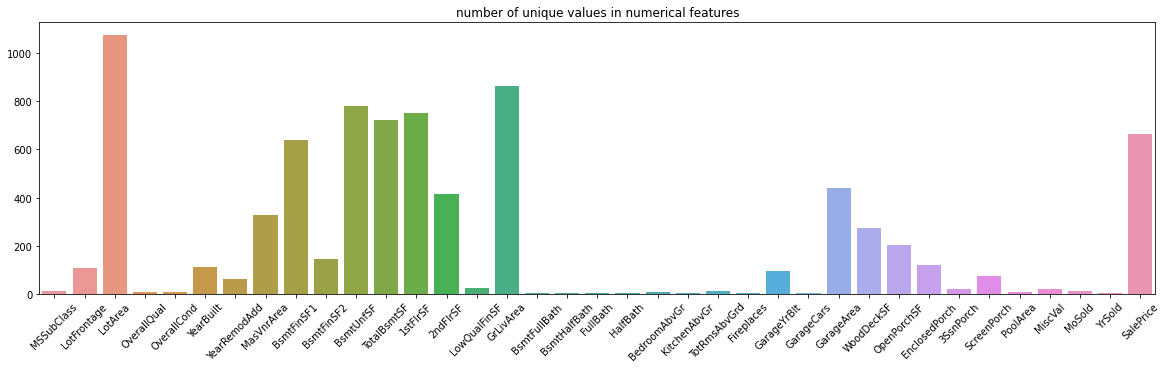

In [25]:
num_unique = train_df_numerical.nunique()
plt.figure(figsize=(20, 5))
sns.barplot(x=num_unique.index, y=num_unique.values)
plt.xticks(rotation=45)
plt.title('number of unique values in numerical features')

Well, in some of the numerical column the number of unique features is very low. May be they are categorical features in numerical format.

To keep things simpler, we will use pandas to_dummies() function to convert the whole dataset into ohe format. Before that, we should replace the missing values.

In [26]:
train_df = train_df.fillna(-999)

In [27]:
y = train_df.SalePrice
X = train_df.iloc[:, :-1]
X = pd.get_dummies(X)

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [30]:
model = XGBRegressor(
    max_depth=6, 
    n_estimators=512, 
    random_state=1,colsample_bytree=0.8, learning_rate=0.001
    )

In [ ]:
model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
          early_stopping_rounds=15)

[16:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:199943
Will train until validation_0-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:199762
[2]	validation_0-rmse:199579
[3]	validation_0-rmse:199398
[4]	validation_0-rmse:199214
[5]	validation_0-rmse:199033
[6]	validation_0-rmse:198853
[7]	validation_0-rmse:198675
[8]	validation_0-rmse:198495
[9]	validation_0-rmse:198314
[10]	validation_0-rmse:198133
[11]	validation_0-rmse:197952
[12]	validation_0-rmse:197772
[13]	validation_0-rmse:197593
[14]	validation_0-rmse:197413
[15]	validation_0-rmse:197236
[16]	validation_0-rmse:197056
[17]	validation_0-rmse:196877
[18]	validation_0-rmse:196698
[19]	validation_0-rmse:196519
[20]	validation_0-rmse:196344
[21]	validation_0-rmse:196168
[22]	validation_0-rmse:195989
[23]	validation_0-rmse:195810
[24]	validation_0-rmse:195633
[25]	validation_0-rmse:195458
[26]	validation_0-rmse:195281
[27]	val

In [ ]:
model.feature_importances_

Let's see top 10 most important features.

In [ ]:
plt.figure(figsize=(10, 10))
xgboost.plot_importance(model, max_num_features=10, height=0.2)